In [1]:
# conda base

# Data manipulation 
import pandas as pd 
import numpy as np
import os

# smiles manipulation
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import AllChem, Draw
from rdkit import DataStructs
from rdkit import Chem
import itertools
import scipy.cluster.hierarchy as shc

# Data viz
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import seaborn as sns

This notebook shows how to merge the data of sequences retrived from [BLDB](http://bldb.eu/) and MICs from [BLDB2](https://ifr48.timone.univ-mrs.fr/beta-lactamase/public/) to create the main dataset. It also includes the procedure to create a second dataset of enzyme kinetics not analyzed in this master thesis. Finally shows how to compute the tanimoto similarity between 50 betalactam antibiotics.


## Tanimoto similarity

In [5]:
# antibiotic classes
penicillins = ["Amoxicillin", "Ampicillin", "PenicillinV", "PenicillinG","Dicloxacillin", "Nafcillin", "Oxacillin", 
               "Azlocillin", "Carbenicillin", "Methicillin", "Mezlocillin", "Piperacillin", "Ticarcillin", "Cloxacillin"]

cephalosporins_1 = ["Cefadroxil", "Cephalexin","Cephradine","Cephalothin","Cephapirin","Cefazolin"]

cephalosporins_2 = ["Cefamandole","Cefmetazole","Cefonicid","Cefotetan","Cefoxitin","Cefuroxime","Cefaclor"]

cephalosporins_3 = ["Cefixime","Cefoperazone","Cefotaxime","Ceftazidime","Ceftizoxime","Ceftriaxone","Moxalactam"]

cephalosporins_4 = ["Cefepime","Cefozopran","Cefpirome","Cefquinome"]

cephalosporins_5 = ["Ceftaroline_fosamil","Ceftobiprole"]

cephalosporins = cephalosporins_1 + cephalosporins_2 + cephalosporins_3 + cephalosporins_4 + cephalosporins_5

carbapenems = ["Imipenem","Meropenem","Biapenem","Doripenem","Ertapenem","Panipenem"]

monobactams = ["Aztreonam","Carumonam","Nocardicin_a","Tigemonam"]

## retrive data 

Per each antibiotic, retrive the canonical and isomeric SMILES (includes stereochemical info) from PubChem. As an example for Ampicillin:
https://pubchem.ncbi.nlm.nih.gov/compound/Ampicillin

In [6]:
print(penicillins)

['Amoxicillin', 'Ampicillin', 'PenicillinV', 'PenicillinG', 'Dicloxacillin', 'Nafcillin', 'Oxacillin', 'Azlocillin', 'Carbenicillin', 'Methicillin', 'Mezlocillin', 'Piperacillin', 'Ticarcillin', 'Cloxacillin']


In [7]:
canon_peni = [
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C", # Amoxicillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O)O)C", # Ampicillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)O)C", # PenicillinV
    "CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C", # PenicillinG
    "CC1=C(C(=NO1)C2=C(C=CC=C2Cl)Cl)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O", # Dicloxacillin
    "CCOC1=C(C2=CC=CC=C2C=C1)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O", # Nafcillin,
    "CC1=C(C(=NO1)C2=CC=CC=C2)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O", # Oxacillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)NC(=O)N4CCNC4=O)C(=O)O)C", # Azlocillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)C(=O)O)C(=O)O)C", # Carbenicillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C3=C(C=CC=C3OC)OC)C(=O)O)C", # Methicillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)NC(=O)N4CCN(C4=O)S(=O)(=O)C)C(=O)O)C", # Mezlocillin
    "CCN1CCN(C(=O)C1=O)C(=O)NC(C2=CC=CC=C2)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O", # Piperacillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CSC=C3)C(=O)O)C(=O)O)C", # Ticarcillin
    "CC1=C(C(=NO1)C2=CC=CC=C2Cl)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O", # Cloxacillin
]

iso_peni = [
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=C(C=C3)O)N)C(=O)O)C", # Amoxicillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=CC=C3)N)C(=O)O)C", # Ampicillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)COC3=CC=CC=C3)C(=O)O)C", # PenicillinV
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C", # PenicillinG
    "CC1=C(C(=NO1)C2=C(C=CC=C2Cl)Cl)C(=O)N[C@H]3[C@@H]4N(C3=O)[C@H](C(S4)(C)C)C(=O)O", # Dicloxacillin
    "CCOC1=C(C2=CC=CC=C2C=C1)C(=O)N[C@H]3[C@@H]4N(C3=O)[C@H](C(S4)(C)C)C(=O)O", # Nafcillin
    "CC1=C(C(=NO1)C2=CC=CC=C2)C(=O)N[C@H]3[C@@H]4N(C3=O)[C@H](C(S4)(C)C)C(=O)O", # Oxacillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=CC=C3)NC(=O)N4CCNC4=O)C(=O)O)C", # Azlocillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)C(C3=CC=CC=C3)C(=O)O)C(=O)O)C", # Carbenicillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)C3=C(C=CC=C3OC)OC)C(=O)O)C", # Methicillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=CC=C3)NC(=O)N4CCN(C4=O)S(=O)(=O)C)C(=O)O)C", # Mezlocillin
    "CCN1CCN(C(=O)C1=O)C(=O)N[C@H](C2=CC=CC=C2)C(=O)N[C@H]3[C@@H]4N(C3=O)[C@H](C(S4)(C)C)C(=O)O", # Piperacillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CSC=C3)C(=O)O)C(=O)O)C", # Ticarcillin
    "CC1=C(C(=NO1)C2=CC=CC=C2Cl)C(=O)N[C@H]3[C@@H]4N(C3=O)[C@H](C(S4)(C)C)C(=O)O", # Cloxacillin
]

dic_can_pen = dict(zip(penicillins, canon_peni))
dic_iso_pen = dict(zip(penicillins, iso_peni))

In [8]:
print(cephalosporins_1)

['Cefadroxil', 'Cephalexin', 'Cephradine', 'Cephalothin', 'Cephapirin', 'Cefazolin']


In [9]:
canon_ceph1 = [
    "CC1=C(N2C(C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)SC1)C(=O)O", #Cefadroxil
    "CC1=C(N2C(C(C2=O)NC(=O)C(C3=CC=CC=C3)N)SC1)C(=O)O", #Cephalexin
    "CC1=C(N2C(C(C2=O)NC(=O)C(C3=CCC=CC3)N)SC1)C(=O)O", #Cephradine
    "CC(=O)OCC1=C(N2C(C(C2=O)NC(=O)CC3=CC=CS3)SC1)C(=O)O", #Cephalothin
    "CC(=O)OCC1=C(N2C(C(C2=O)NC(=O)CSC3=CC=NC=C3)SC1)C(=O)O", #Cephapirin
    "CC1=NN=C(S1)SCC2=C(N3C(C(C3=O)NC(=O)CN4C=NN=N4)SC2)C(=O)O" #Cefazolin
]

iso_ceph1 = [
    "CC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)[C@@H](C3=CC=C(C=C3)O)N)SC1)C(=O)O", #Cefadroxil
    "CC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)[C@@H](C3=CC=CC=C3)N)SC1)C(=O)O", #Cephalexin
    "CC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)[C@@H](C3=CCC=CC3)N)SC1)C(=O)O", #Cephradine
    "CC(=O)OCC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)CC3=CC=CS3)SC1)C(=O)O", #Cephalothin
    "CC(=O)OCC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)CSC3=CC=NC=C3)SC1)C(=O)O", #Cephapirin
    "CC1=NN=C(S1)SCC2=C(N3[C@@H]([C@@H](C3=O)NC(=O)CN4C=NN=N4)SC2)C(=O)O" #Cefazolin
]

dic_can_cep1 = dict(zip(cephalosporins_1, canon_ceph1))
dic_iso_cep1 = dict(zip(cephalosporins_1, iso_ceph1))

In [10]:
print(cephalosporins_2)

['Cefamandole', 'Cefmetazole', 'Cefonicid', 'Cefotetan', 'Cefoxitin', 'Cefuroxime', 'Cefaclor']


In [11]:
canon_ceph2 = [
    "CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)NC(=O)C(C4=CC=CC=C4)O)SC2)C(=O)O", #Cefamandole
    "CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)(NC(=O)CSCC#N)OC)SC2)C(=O)O", #Cefmetazole
    "C1C(=C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)O)C(=O)O)CSC4=NN=NN4CS(=O)(=O)O", #Cefonicid
    "CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)(NC(=O)C4SC(=C(C(=O)N)C(=O)O)S4)OC)SC2)C(=O)O", #Cefotetan
    "COC1(C2N(C1=O)C(=C(CS2)COC(=O)N)C(=O)O)NC(=O)CC3=CC=CS3", #Cefoxitin 
    "CON=C(C1=CC=CO1)C(=O)NC2C3N(C2=O)C(=C(CS3)COC(=O)N)C(=O)O", #Cefuroxime
    "C1C(=C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O)O)Cl" #Cefaclor
]

iso_ceph2 = [
    "CN1C(=NN=N1)SCC2=C(N3[C@@H]([C@@H](C3=O)NC(=O)[C@@H](C4=CC=CC=C4)O)SC2)C(=O)O", #Cefamandole
    "CN1C(=NN=N1)SCC2=C(N3[C@@H]([C@@](C3=O)(NC(=O)CSCC#N)OC)SC2)C(=O)O", #Cefmetazole
    "C1C(=C(N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=CC=C3)O)C(=O)O)CSC4=NN=NN4CS(=O)(=O)O", #Cefonicid
    "CN1C(=NN=N1)SCC2=C(N3[C@@H]([C@@](C3=O)(NC(=O)C4SC(=C(C(=O)N)C(=O)O)S4)OC)SC2)C(=O)O", #Cefotetan
    "CO[C@@]1([C@@H]2N(C1=O)C(=C(CS2)COC(=O)N)C(=O)O)NC(=O)CC3=CC=CS3", #Cefoxitin 
    "CO/N=C(/C1=CC=CO1)\C(=O)N[C@H]2[C@@H]3N(C2=O)C(=C(CS3)COC(=O)N)C(=O)O", #Cefuroxime
    "C1C(=C(N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=CC=C3)N)C(=O)O)Cl" #Cefaclor
]

dic_can_cep2 = dict(zip(cephalosporins_2, canon_ceph2))
dic_iso_cep2 = dict(zip(cephalosporins_2, iso_ceph2))

In [12]:
print(cephalosporins_3)

['Cefixime', 'Cefoperazone', 'Cefotaxime', 'Ceftazidime', 'Ceftizoxime', 'Ceftriaxone', 'Moxalactam']


In [13]:
canon_ceph3 = [
    "C=CC1=C(N2C(C(C2=O)NC(=O)C(=NOCC(=O)O)C3=CSC(=N3)N)SC1)C(=O)O", # Cefixime
    "CCN1CCN(C(=O)C1=O)C(=O)NC(C2=CC=C(C=C2)O)C(=O)NC3C4N(C3=O)C(=C(CS4)CSC5=NN=NN5C)C(=O)O", # Cefoperazone
    "CC(=O)OCC1=C(N2C(C(C2=O)NC(=O)C(=NOC)C3=CSC(=N3)N)SC1)C(=O)O", # Cefotaxime
    "CC(C)(C(=O)O)ON=C(C1=CSC(=N1)N)C(=O)NC2C3N(C2=O)C(=C(CS3)C[N+]4=CC=CC=C4)C(=O)[O-]", # Ceftazidime
    "CON=C(C1=CSC(=N1)N)C(=O)NC2C3N(C2=O)C(=CCS3)C(=O)O", # Ceftizoxime
    "CN1C(=NC(=O)C(=O)N1)SCC2=C(N3C(C(C3=O)NC(=O)C(=NOC)C4=CSC(=N4)N)SC2)C(=O)O", # Ceftriaxone
    "CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)(NC(=O)C(C4=CC=C(C=C4)O)C(=O)O)OC)OC2)C(=O)O" # Moxalactam
]

# isomerci Ceftizoxime not apprear by name, but yes by compound id
# https://pubchem.ncbi.nlm.nih.gov/compound/Ceftizoxima#section=InChI
iso_ceph3 = [
    "C=CC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)/C(=N\OCC(=O)O)/C3=CSC(=N3)N)SC1)C(=O)O",# Cefixime
    "CCN1CCN(C(=O)C1=O)C(=O)N[C@H](C2=CC=C(C=C2)O)C(=O)N[C@H]3[C@@H]4N(C3=O)C(=C(CS4)CSC5=NN=NN5C)C(=O)O",# Cefoperazone
    "CC(=O)OCC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)/C(=N\OC)/C3=CSC(=N3)N)SC1)C(=O)O", # Cefotaxime
    "CC(C)(C(=O)O)O/N=C(/C1=CSC(=N1)N)\C(=O)N[C@H]2[C@@H]3N(C2=O)C(=C(CS3)C[N+]4=CC=CC=C4)C(=O)[O-]",# Ceftazidime
    "CO/N=C(/C1=CSC(=N1)N)\C(=O)N[C@H]2[C@@H]3N(C2=O)C(=CCS3)C(=O)O", # Ceftizoxime
    "CN1C(=NC(=O)C(=O)N1)SCC2=C(N3[C@@H]([C@@H](C3=O)NC(=O)/C(=N\OC)/C4=CSC(=N4)N)SC2)C(=O)O", # Ceftriaxone
    "CN1C(=NN=N1)SCC2=C(N3[C@@H]([C@@](C3=O)(NC(=O)C(C4=CC=C(C=C4)O)C(=O)O)OC)OC2)C(=O)O" # Moxalactam
]

dic_can_cep3 = dict(zip(cephalosporins_3, canon_ceph3))
dic_iso_cep3 = dict(zip(cephalosporins_3, iso_ceph3))

In [14]:
print(cephalosporins_4)

['Cefepime', 'Cefozopran', 'Cefpirome', 'Cefquinome']


In [15]:
canon_ceph4 = [
    "C[N+]1(CCCC1)CC2=C(N3C(C(C3=O)NC(=O)C(=NOC)C4=CSC(=N4)N)SC2)C(=O)[O-]", # Cefepime
    "CON=C(C1=NSC(=N1)N)C(=O)NC2C3N(C2=O)C(=C(CS3)C[N+]4=C5C=CC=NN5C=C4)C(=O)[O-]", # Cefozopran
    "CON=C(C1=CSC(=N1)N)C(=O)NC2C3N(C2=O)C(=C(CS3)C[N+]4=CC=CC5=C4CCC5)C(=O)[O-]", # Cefpirome
    "CON=C(C1=CSC(=N1)N)C(=O)NC2C3N(C2=O)C(=C(CS3)C[N+]4=CC=CC5=C4CCCC5)C(=O)[O-]" # Cefquinome
]

# isomerci Cefozopran not apprear by name, but yes by compound id
# https://pubchem.ncbi.nlm.nih.gov/compound/5464317#section=InChI
iso_ceph4 = [
    "C[N+]1(CCCC1)CC2=C(N3[C@@H]([C@@H](C3=O)NC(=O)/C(=N\OC)/C4=CSC(=N4)N)SC2)C(=O)[O-]",  # Cefepime
    "CO/N=C(\C1=NSC(=N1)N)/C(=O)N[C@H]2[C@@H]3N(C2=O)C(=C(CS3)C[N+]4=C5C=CC=NN5C=C4)C(=O)[O-]", # Cefozopran
    "CO/N=C(/C1=CSC(=N1)N)\C(=O)N[C@H]2[C@@H]3N(C2=O)C(=C(CS3)C[N+]4=CC=CC5=C4CCC5)C(=O)[O-]", # Cefpirome
    "CO/N=C(/C1=CSC(=N1)N)\C(=O)N[C@H]2[C@@H]3N(C2=O)C(=C(CS3)C[N+]4=CC=CC5=C4CCCC5)C(=O)[O-]" # Cefquinome
]

dic_can_cep4 = dict(zip(cephalosporins_4, canon_ceph4))
dic_iso_cep4 = dict(zip(cephalosporins_4, iso_ceph4))

In [16]:
print(cephalosporins_5)

['Ceftaroline_fosamil', 'Ceftobiprole']


In [17]:
canon_ceph5 = [
    "CCON=C(C1=NSC(=N1)NP(=O)(O)O)C(=O)NC2C3N(C2=O)C(=C(CS3)SC4=NC(=CS4)C5=CC=[N+](C=C5)C)C(=O)[O-]", # Ceftaroline_fosamil
    "C1CNCC1N2CCC(=CC3=C(N4C(C(C4=O)NC(=O)C(=NO)C5=NSC(=N5)N)SC3)C(=O)O)C2=O" # Ceftobiprole
]

iso_ceph5 = [
    "CCO/N=C(/C1=NSC(=N1)NP(=O)(O)O)\C(=O)N[C@H]2[C@@H]3N(C2=O)C(=C(CS3)SC4=NC(=CS4)C5=CC=[N+](C=C5)C)C(=O)[O-]",  # Ceftaroline_fosamil
    "C1CNC[C@@H]1N2CC/C(=C\C3=C(N4[C@@H]([C@@H](C4=O)NC(=O)/C(=N\O)/C5=NSC(=N5)N)SC3)C(=O)O)/C2=O"  # Ceftobiprole
]


dic_can_cep5 = dict(zip(cephalosporins_5, canon_ceph5))
dic_iso_cep5 = dict(zip(cephalosporins_5, iso_ceph5))

In [18]:
print(monobactams)

['Aztreonam', 'Carumonam', 'Nocardicin_a', 'Tigemonam']


In [19]:
canon_mono = [
    "CC1C(C(=O)N1S(=O)(=O)O)NC(=O)C(=NOC(C)(C)C(=O)O)C2=CSC(=N2)N", # Aztreonam
    "C1=C(N=C(S1)N)C(=NOCC(=O)O)C(=O)NC2C(N(C2=O)S(=O)(=O)O)COC(=O)N", # Carumonam
    "C1C(C(=O)N1C(C2=CC=C(C=C2)O)C(=O)O)NC(=O)C(=NO)C3=CC=C(C=C3)OCCC(C(=O)O)N", # Nocardicin_a
    "CC1(C(C(=O)N1OS(=O)(=O)O)NC(=O)C(=NOCC(=O)O)C2=CSC(=N2)N)C" # Tigemonam
]

# isomerci aztreonam not apprear by name, but yes by compound id
# https://pubchem.ncbi.nlm.nih.gov/compound/5459211
iso_mono = [
    "C[C@H]1[C@@H](C(=O)N1S(=O)(=O)O)NC(=O)/C(=N/OC(C)(C)C(=O)O)/C2=CSC(=N2)N", # Aztreonam
    "C1=C(N=C(S1)N)/C(=N/OCC(=O)O)/C(=O)N[C@H]2[C@H](N(C2=O)S(=O)(=O)O)COC(=O)N", # Carumonam
    "C1[C@@H](C(=O)N1[C@H](C2=CC=C(C=C2)O)C(=O)O)NC(=O)/C(=N\O)/C3=CC=C(C=C3)OCC[C@H](C(=O)O)N",  # Nocardicin_a
    "CC1([C@@H](C(=O)N1OS(=O)(=O)O)NC(=O)/C(=N\OCC(=O)O)/C2=CSC(=N2)N)C" # Tigemonam
]

dic_can_mon = dict(zip(monobactams, canon_mono))
dic_iso_mon = dict(zip(monobactams, iso_mono))

In [20]:
print(carbapenems)

['Imipenem', 'Meropenem', 'Biapenem', 'Doripenem', 'Ertapenem', 'Panipenem']


In [21]:
canon_carb = [
    "CC(C1C2CC(=C(N2C1=O)C(=O)O)SCCN=CN)O", # Imipenem
    "CC1C2C(C(=O)N2C(=C1SC3CC(NC3)C(=O)N(C)C)C(=O)O)C(C)O", # Meropenem
    "CC1C2C(C(=O)N2C(=C1SC3CN4C=NC=[N+]4C3)C(=O)[O-])C(C)O", # Biapenem
    "CC1C2C(C(=O)N2C(=C1SC3CC(NC3)CNS(=O)(=O)N)C(=O)O)C(C)O", # Doripenem
    "CC1C2C(C(=O)N2C(=C1SC3CC(NC3)C(=O)NC4=CC=CC(=C4)C(=O)O)C(=O)O)C(C)O", # Ertapenem
    "CC(C1C2CC(=C(N2C1=O)C(=O)O)SC3CCN(C3)C(=N)C)O" # Panipenem
]

iso_carb = [
    "C[C@H]([C@@H]1[C@H]2CC(=C(N2C1=O)C(=O)O)SCCN=CN)O",  # Imipenem
    "C[C@@H]1[C@@H]2[C@H](C(=O)N2C(=C1S[C@H]3C[C@H](NC3)C(=O)N(C)C)C(=O)O)[C@@H](C)O", # Meropenem
    "C[C@@H]1[C@@H]2[C@H](C(=O)N2C(=C1SC3CN4C=NC=[N+]4C3)C(=O)[O-])[C@@H](C)O",# Biapenem
    "C[C@@H]1[C@@H]2[C@H](C(=O)N2C(=C1S[C@H]3C[C@H](NC3)CNS(=O)(=O)N)C(=O)O)[C@@H](C)O",# Doripenem
    "C[C@@H]1[C@@H]2[C@H](C(=O)N2C(=C1S[C@H]3C[C@H](NC3)C(=O)NC4=CC=CC(=C4)C(=O)O)C(=O)O)[C@@H](C)O",# Ertapenem
    "C[C@H]([C@@H]1[C@H]2CC(=C(N2C1=O)C(=O)O)S[C@H]3CCN(C3)C(=N)C)O"# Panipenem
]

dic_can_car = dict(zip(carbapenems, canon_carb))
dic_iso_car = dict(zip(carbapenems, iso_carb))

In [22]:
# merge dicts 
dic_can = dic_can_pen|dic_can_cep1|dic_can_cep2|dic_can_cep3|dic_can_cep4|dic_can_cep5|dic_can_mon|dic_can_car
dic_iso = dic_iso_pen|dic_iso_cep1|dic_iso_cep2|dic_iso_cep3|dic_iso_cep4|dic_iso_cep5|dic_iso_mon|dic_iso_car

# create a df
df_smiles = pd.DataFrame()
df_smiles["antibiotic"] = dic_can.keys()

# simplified notation
filters = [df_smiles.antibiotic.str.contains('|'.join(penicillins)), 
           df_smiles.antibiotic.str.contains('|'.join(cephalosporins)),
           df_smiles.antibiotic.str.contains('|'.join(carbapenems)),
           df_smiles.antibiotic.str.contains('|'.join(monobactams))]
values = ["Penicillins", "Cephalosporins", "Carbapenems", "Monobactams"]
df_smiles["antibiotic_class"] = np.select(filters, values)

# extendend notation
filters2 = [df_smiles.antibiotic.str.contains('|'.join(penicillins)), 
           df_smiles.antibiotic.str.contains('|'.join(cephalosporins_1)),
           df_smiles.antibiotic.str.contains('|'.join(cephalosporins_2)),
           df_smiles.antibiotic.str.contains('|'.join(cephalosporins_3)),
           df_smiles.antibiotic.str.contains('|'.join(cephalosporins_4)),
           df_smiles.antibiotic.str.contains('|'.join(cephalosporins_5)),
           df_smiles.antibiotic.str.contains('|'.join(carbapenems)),
           df_smiles.antibiotic.str.contains('|'.join(monobactams))]

values2 = ["Penicillins", "1°G Cephalosporins" , "2°G Cephalosporins", "3°G Cephalosporins", "4°G Cephalosporins",
          "5°G Cephalosporins", "Carbapenems", "Monobactams"]
df_smiles["anti_class_expand"] = np.select(filters2, values2)

# add smiles
df_smiles["canonical_smile"] = dic_can.values()
df_smiles["isomeric_smile"] = dic_iso.values()
df_smiles.to_csv("../results/tanimoto/betalactam_antibiotics_smiles.csv", index = False)
df_smiles

,antibiotic,antibiotic_class,anti_class_expand,canonical_smile,isomeric_smile
0,Amoxicillin,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H]...
1,Ampicillin,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H]...
2,PenicillinV,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)O)C,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)COC3=C...
3,PenicillinG,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
4,Dicloxacillin,Penicillins,Penicillins,CC1=C(C(=NO1)C2=C(C=CC=C2Cl)Cl)C(=O)NC3C4N(C3=...,CC1=C(C(=NO1)C2=C(C=CC=C2Cl)Cl)C(=O)N[C@H]3[C@...
5,Nafcillin,Penicillins,Penicillins,CCOC1=C(C2=CC=CC=C2C=C1)C(=O)NC3C4N(C3=O)C(C(S...,CCOC1=C(C2=CC=CC=C2C=C1)C(=O)N[C@H]3[C@@H]4N(C...
6,Oxacillin,Penicillins,Penicillins,CC1=C(C(=NO1)C2=CC=CC=C2)C(=O)NC3C4N(C3=O)C(C(...,CC1=C(C(=NO1)C2=CC=CC=C2)C(=O)N[C@H]3[C@@H]4N(...
7,Azlocillin,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)NC(=O)...,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H]...
8,Carbenicillin,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)C(=O)O...,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)C(C3=C...
9,Methicillin,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)C3=C(C=CC=C3OC)OC)C(...,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)C3=C(C...


## calculate tanimoto

The Tanimoto similarity is a metric that depends on the amount of information used to calculate it. With more SMILES used to generate a bank of structrues, more chemical characteristics can be considered to calculate the similarity.

In [23]:
# a quick example 
# def tanimoto(smile1, smile2):
#     mol1 = Chem.MolFromSmiles(smile1)
#     mol2 = Chem.MolFromSmiles(smile2)
#     fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits=2048)
#     fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits=2048)
#     s = round(DataStructs.TanimotoSimilarity(fp1,fp2),3)
#     return s
# 
# imipenem_example = "CC(C1C2CC(=C(N2C1=O)C(=O)O)SCCN=CN)O"
# ampicilin_example = "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O)O)C"
# 
# print(f"Tanimoto sim. between imipenem and imipenem = {tanimoto(imipenem_example, imipenem_example)}")
# print(f"Tanimoto sim. between imipenem and ampicillin = {tanimoto(imipenem_example, ampicilin_example)}")

In [2]:
# read data  (checkpont)
df_smiles = pd.read_csv("../results/tanimoto/betalactam_antibiotics_smiles.csv")

# create a function to build a tanimoto matrix
# https://twitter.com/andrewwhite01/status/1463155348584472585/photo/1
def tanimoto_matrix(smiles_list):
    
    "compute the tanimoto similarity given a list of smiles as strings"
    
    fp = [Chem.AllChem.GetMorganFingerprint(Chem.MolFromSmiles(s),2) for s in smiles_list]
    ts = list(TanimotoSimilarity(x, y) for x, y in itertools.product(fp, repeat = 2))
    return np.array(ts).reshape(len(fp), len(fp))

In [3]:
df_smiles.head()

,antibiotic,antibiotic_class,anti_class_expand,canonical_smile,isomeric_smile
0,Amoxicillin,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H]...
1,Ampicillin,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H]...
2,PenicillinV,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)O)C,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)COC3=C...
3,PenicillinG,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
4,Dicloxacillin,Penicillins,Penicillins,CC1=C(C(=NO1)C2=C(C=CC=C2Cl)Cl)C(=O)NC3C4N(C3=...,CC1=C(C(=NO1)C2=C(C=CC=C2Cl)Cl)C(=O)N[C@H]3[C@...


In [4]:
# create mol object 
mols = [Chem.MolFromSmiles(smiles) for smiles in df_smiles.canonical_smile.to_list()]

# get the Morgan fingerprint as 2048d vector 
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in mols]
fp_array = np.array(fps)
fp_array

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [20]:
anti_colors = df_smiles.antibiotic_class.map({
    "Penicillins": "salmon",
    "Cephalosporins": "cornflowerblue",
    "Monobactams": "yellow",
    "Carbapenems": "palegreen"
})

/home/gama/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 0.98, 'clustermap on raw \nmorgan fingerprints (bit. vec. 2048d)')

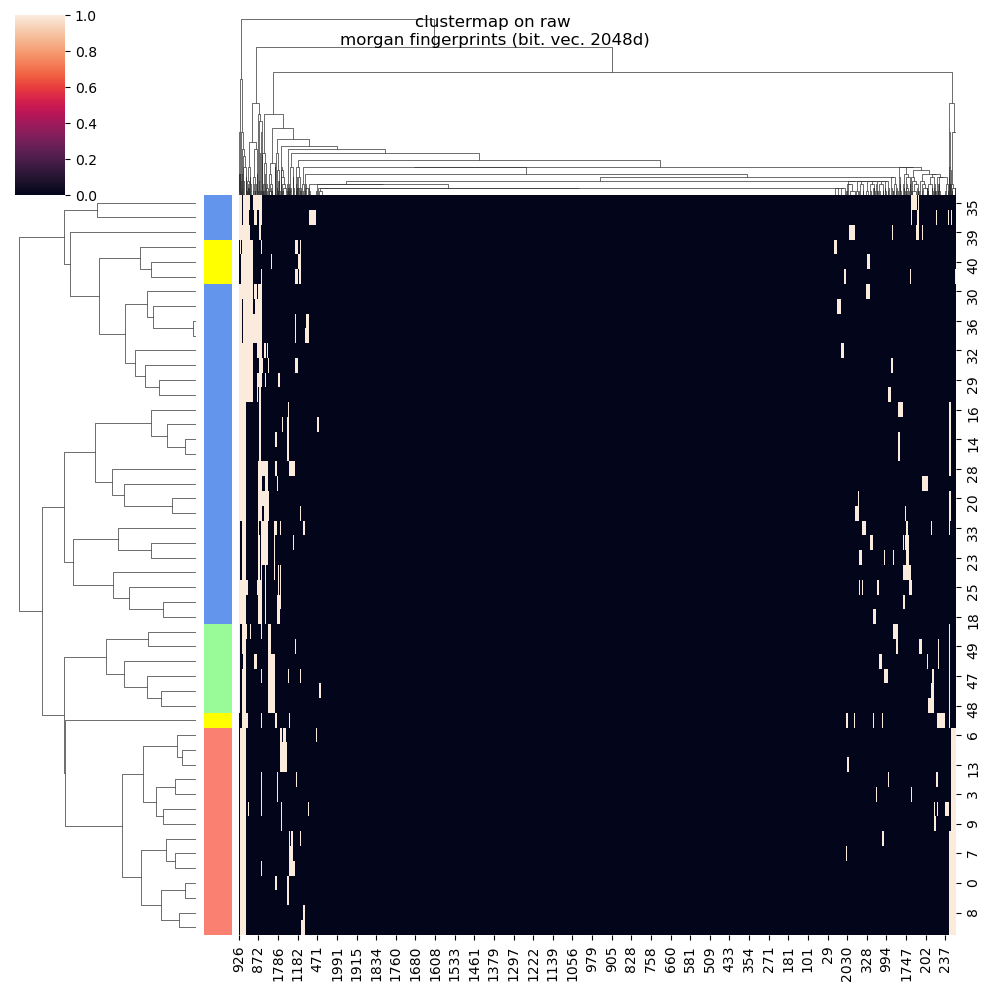

In [35]:
sns.clustermap(fp_array, standard_scale=None, metric="hamming", method="complete",
              row_colors=anti_colors.to_numpy())
plt.suptitle("clustermap on raw \nmorgan fingerprints (bit. vec. 2048d)")

In [36]:
sim_matrix_single = tanimoto_matrix(df_smiles.canonical_smile)
    
# create a df 
df_sim_single = pd.DataFrame(sim_matrix_single, columns = df_smiles.antibiotic)
df_sim_single["antibiotic_class"] = df_smiles.antibiotic_class
df_sim_single["antibiotic"] = df_smiles.antibiotic


antibiotic,Amoxicillin,Ampicillin,PenicillinV,PenicillinG,Dicloxacillin,Nafcillin,Oxacillin,Azlocillin,Carbenicillin,Methicillin,...,Nocardicin_a,Tigemonam,Imipenem,Meropenem,Biapenem,Doripenem,Ertapenem,Panipenem,antibiotic_class,antibiotic
0,1.000000,0.736842,0.528736,0.547619,0.450980,0.500000,0.484536,0.490385,0.593023,0.505495,...,0.296875,0.236842,0.174757,0.192982,0.166667,0.188034,0.226562,0.183486,Penicillins,Amoxicillin
1,0.736842,1.000000,0.679487,0.706667,0.460000,0.542553,0.595506,0.627660,0.776316,0.516854,...,0.205882,0.219298,0.155340,0.175439,0.159292,0.170940,0.220472,0.165138,Penicillins,Ampicillin
2,0.528736,0.679487,1.000000,0.767123,0.455446,0.586957,0.588889,0.524752,0.638554,0.528090,...,0.213235,0.238938,0.142857,0.163793,0.147826,0.159664,0.209302,0.153153,Penicillins,PenicillinV
3,0.547619,0.706667,0.767123,1.000000,0.469388,0.571429,0.609195,0.540816,0.662500,0.528736,...,0.182482,0.223214,0.147059,0.168142,0.151786,0.163793,0.214286,0.157407,Penicillins,PenicillinG
4,0.450980,0.460000,0.455446,0.469388,1.000000,0.504673,0.698925,0.385246,0.438095,0.556701,...,0.161290,0.201550,0.125000,0.162791,0.148438,0.141791,0.212766,0.144000,Penicillins,Dicloxacillin
5,0.500000,0.542553,0.586957,0.571429,0.504673,1.000000,0.602041,0.448276,0.515152,0.578947,...,0.226027,0.212598,0.135593,0.164062,0.140625,0.151515,0.214286,0.145161,Penicillins,Nafcillin
6,0.484536,0.595506,0.588889,0.609195,0.698925,0.602041,1.000000,0.486486,0.563830,0.563830,...,0.181208,0.208000,0.129310,0.168000,0.153226,0.146154,0.218978,0.148760,Penicillins,Oxacillin
7,0.490385,0.627660,0.524752,0.540816,0.385246,0.448276,0.486486,1.000000,0.645833,0.423423,...,0.198718,0.208955,0.136000,0.180451,0.166667,0.176471,0.244755,0.181102,Penicillins,Azlocillin
8,0.593023,0.776316,0.638554,0.662500,0.438095,0.515152,0.563830,0.645833,1.000000,0.489362,...,0.233577,0.230769,0.148148,0.177966,0.152542,0.173554,0.259843,0.168142,Penicillins,Carbenicillin
9,0.505495,0.516854,0.528090,0.528736,0.556701,0.578947,0.563830,0.423423,0.489362,1.000000,...,0.173611,0.230769,0.137615,0.188034,0.152542,0.154472,0.221374,0.157895,Penicillins,Methicillin


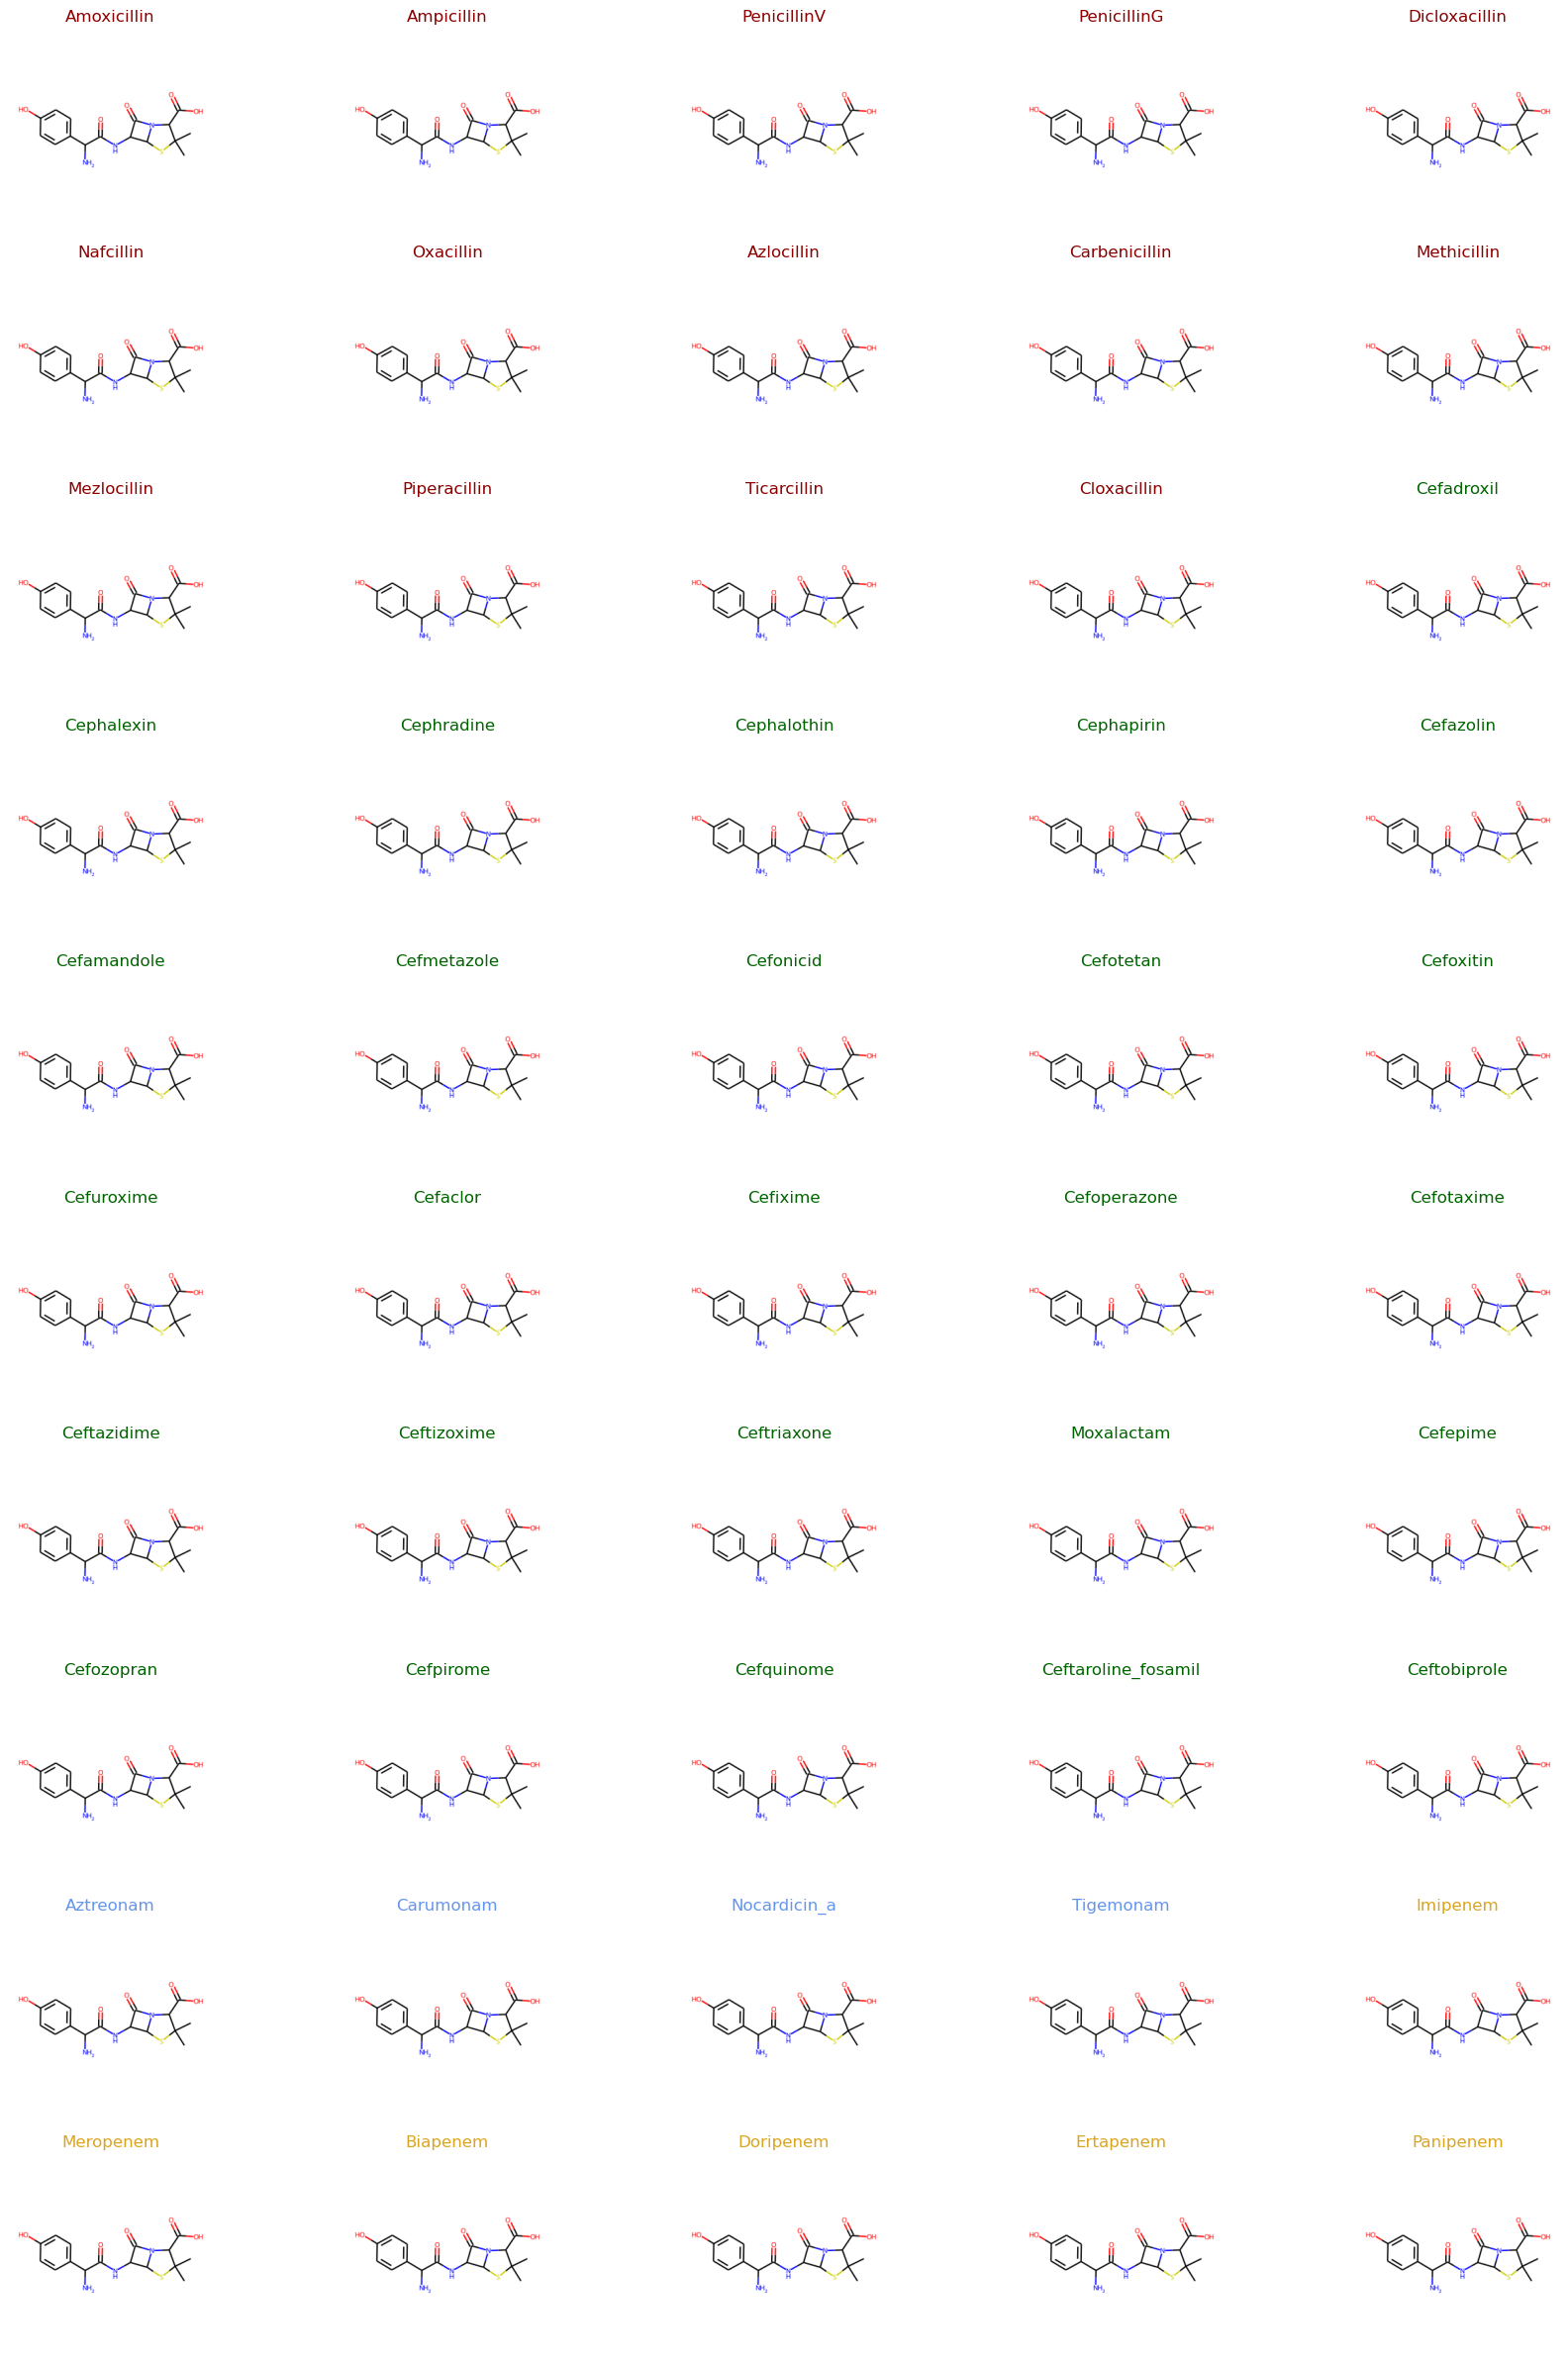

In [13]:


# plot the chem structures
# create a fx to plot mol obj
def plot_mol(mol, name, ax, color):
    # plot a rdkit object
    img = Draw.MolToImage(mol)
    ax.imshow(img)
    ax.set_title(name, color = color)
    ax.set_facecolor("white")
    ax.axis("off")

# set a color palette
colors = {
    "Penicillins": "darkred",
    "Cephalosporins": "darkgreen",
    "Monobactams": "cornflowerblue",
    "Carbapenems": "goldenrod"
}

# plot
fig, axs = plt.subplots(nrows=10, ncols=5, figsize=(18, 24))
for i, row in df_smiles.iterrows():
    ax = axs[i//5, i%5]
    color = colors.get(row["antibiotic_class"], "white")
    mol = Chem.MolFromSmiles(df_smiles['canonical_smile'][0])
    mol_name = mol = Chem.MolFromSmiles(df_smiles['canonical_smile'][0])
    plot_mol(mol, row["antibiotic"], ax, color)
plt.tight_layout()
plt.show()

In [26]:
def tanimoto_plots(smiles_type, name2save, title):
    
    """
    Do a series of plots diven a canonical or isomeric smiles
    """
    
    # compute the tanimoto matrix
    sim_matrix = tanimoto_matrix(smiles_type)
    
    # create a df 
    df_sim = pd.DataFrame(sim_matrix, columns = df_smiles.antibiotic)
    df_sim["antibiotic_class"] = df_smiles.antibiotic_class
    df_sim["antibiotic"] = df_smiles.antibiotic
    # drop anti name col
    dropcol = df_sim.pop("antibiotic")
    # insert column 
    df_sim.insert(0, "antibiotic", dropcol)
    # save df
    path = "../results/tanimoto/" + name2save + ".csv"
    print(f"Dataset saved as: {path}")
    df_sim.to_csv(path, index = False)

    # cluster plot
    # create a color palette and legend structure
    colors = df_sim.antibiotic_class.map({
        "Penicillins": "salmon",
        "Cephalosporins": "palegreen",
        "Monobactams": "cornflowerblue",
        "Carbapenems": "palegoldenrod"})
    lut = dict(zip(df_sim.antibiotic_class.to_list(), colors))
    handles = [Patch(facecolor = lut[name]) for name in lut]
    
    # plot 
    df_num = df_sim.select_dtypes(["number"])
    sns.clustermap(df_num, method = "ward", metric="euclidean",
        cmap = "Spectral_r", figsize=(14, 14), xticklabels = True, yticklabels = df_sim.antibiotic,
        robust = False, row_colors = colors, col_colors = list(colors), cbar_pos = (0.05, 0.76, 0.03,0.2))
    plt.legend(handles, lut, title = "Antibiotic class", loc = "best", frameon = False, ncol = 2,
        bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, prop={'size': 15})
    plt.xlabel(title)
    plt.show()

    # dendogram
    dist_matrix = 1 - df_sim.select_dtypes(["number"]).values
    plt.figure(figsize=(4,8))
    dend = shc.dendrogram(shc.linkage(dist_matrix, method='ward'), 
        labels = df_sim.antibiotic.to_list(), orientation='left', color_threshold=3)
    plt.xlabel("Distance")
    plt.title(title)
    plt.show()
    
    # heatmap
    plt.figure(figsize=(14, 14))
    sns.heatmap(sim_matrix, cmap = "Spectral_r", annot = False, square = True,
    yticklabels = df_sim.antibiotic, xticklabels = df_sim.antibiotic,
    cbar_kws={'label': 'Tanimoto similarity \n (with canonical SMILES)'})
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    # heatmap > 0.5 
    plt.figure(figsize=(5,5))
    plt.imshow(df_num[df_num > 0.5].isna(), aspect="auto", interpolation="nearest", cmap="gray")
    plt.title(title)
    plt.show()

Dataset saved as: ../results/tanimoto/tanimoto_sim_canon.csv


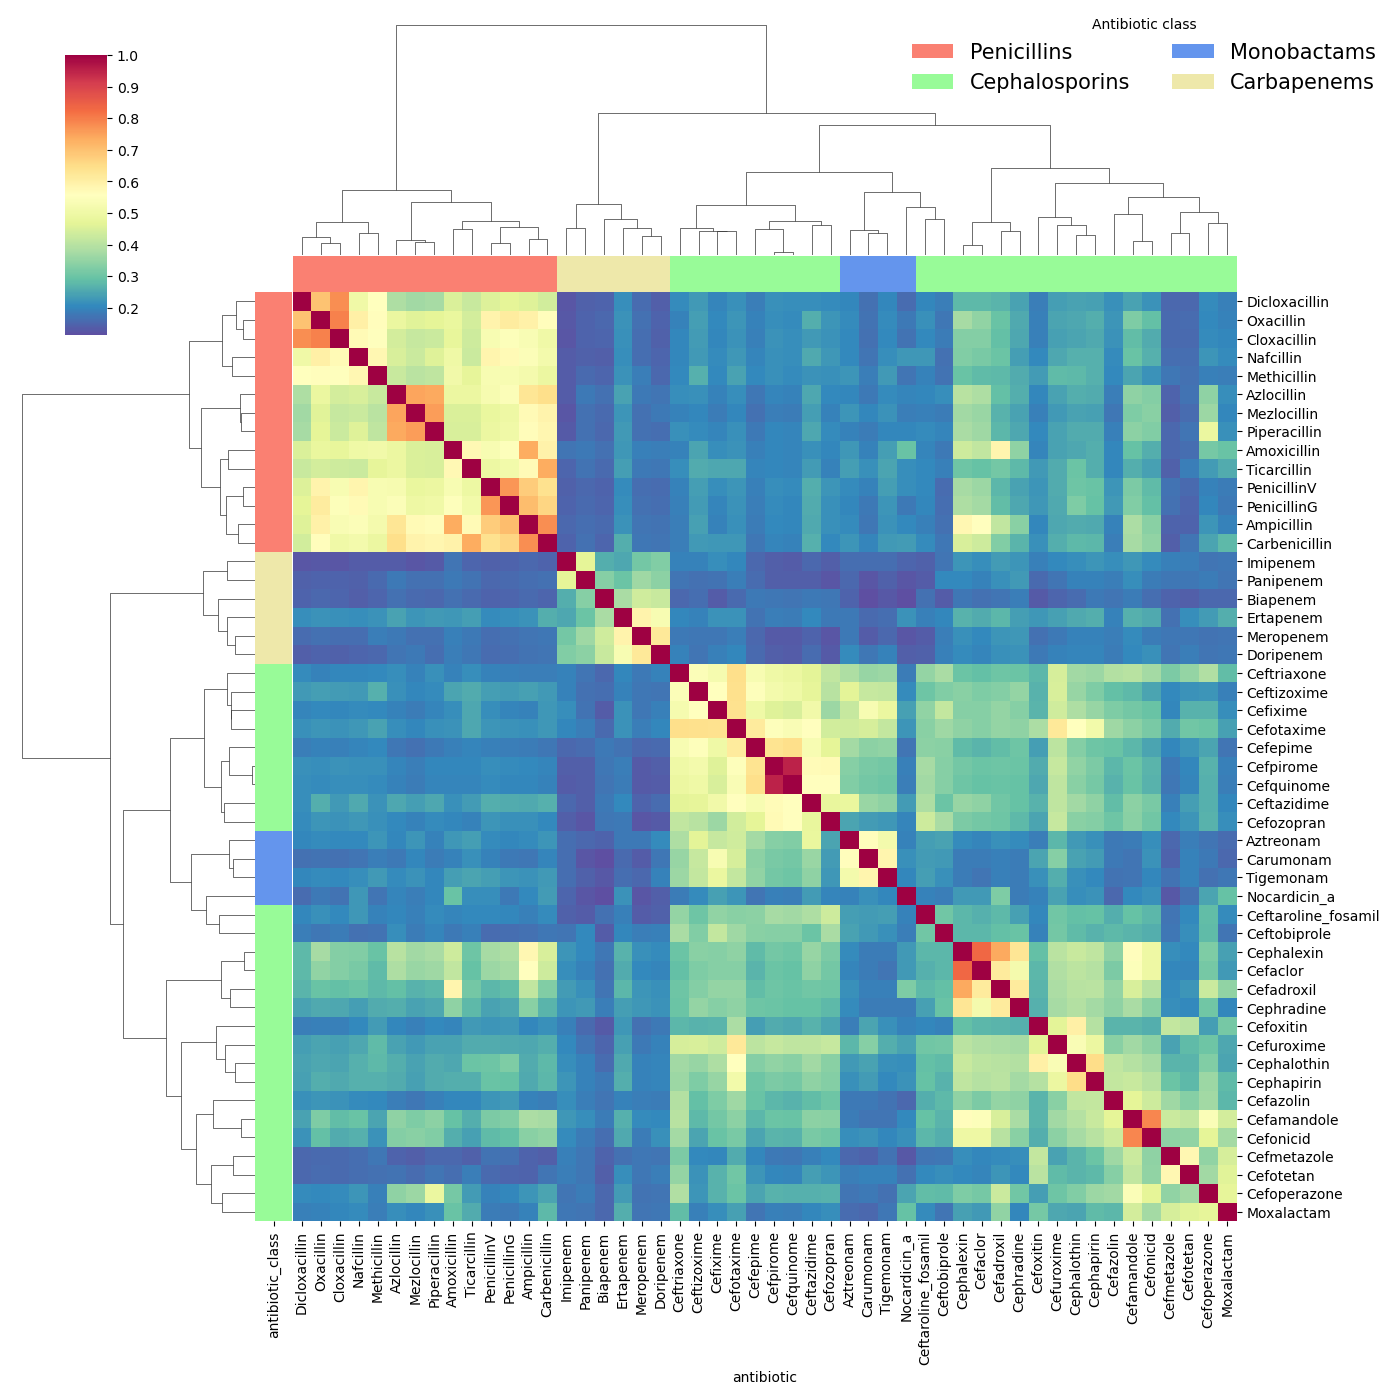

/tmp/ipykernel_1594/1686376322.py:46: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = shc.dendrogram(shc.linkage(dist_matrix, method='ward'),


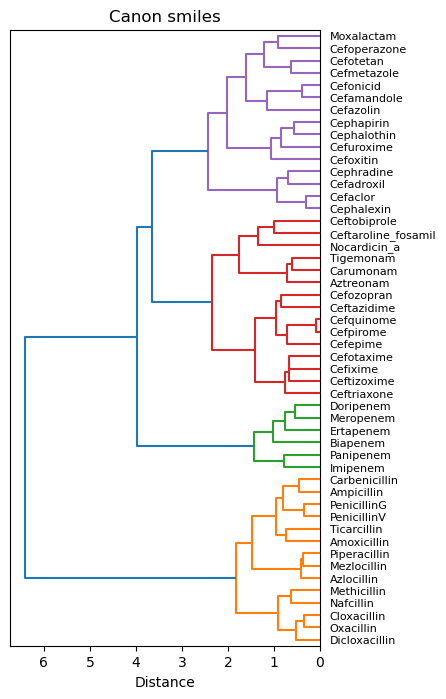

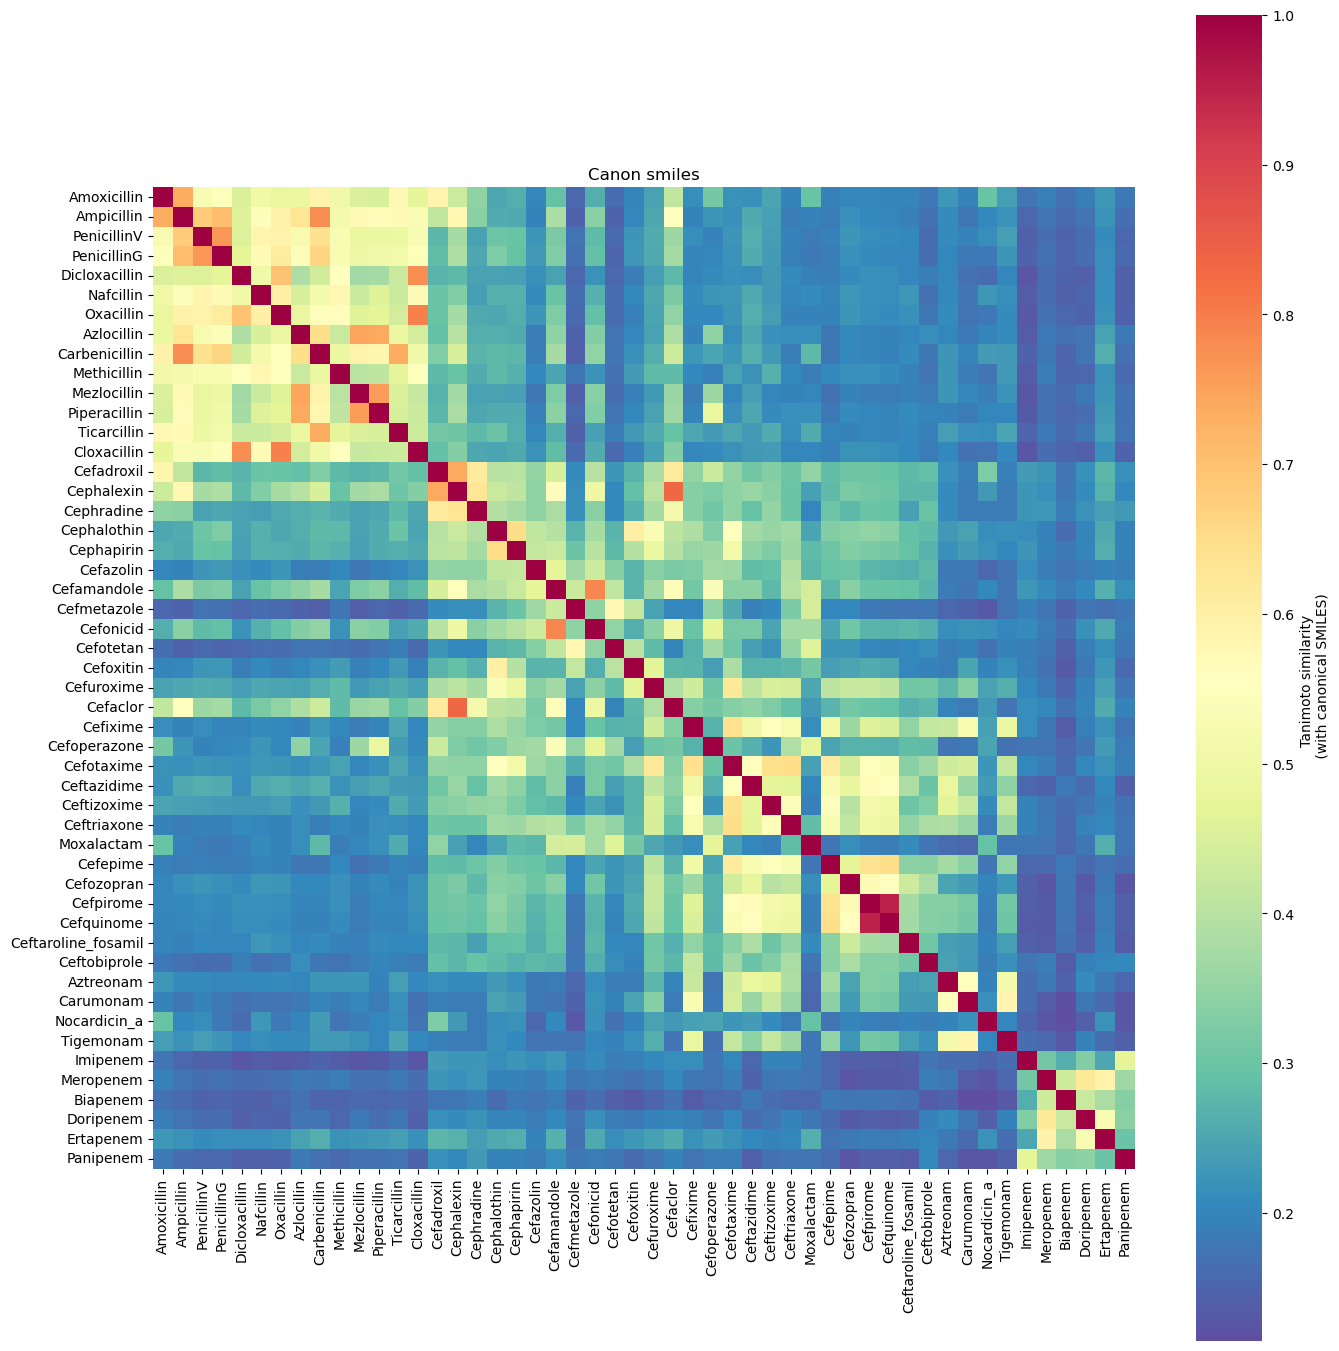

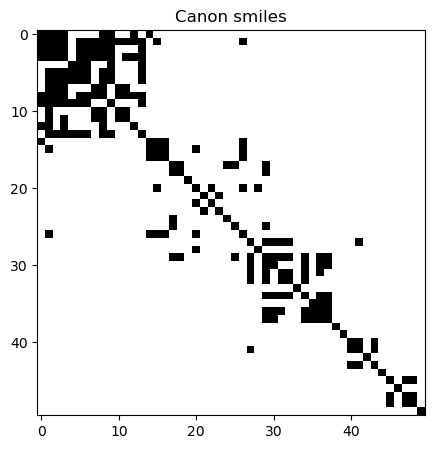

In [27]:
tanimoto_plots(df_smiles.canonical_smile, "tanimoto_sim_canon", "Canon smiles")

Dataset saved as: ../results/tanimoto/tanimoto_sim_iso.csv


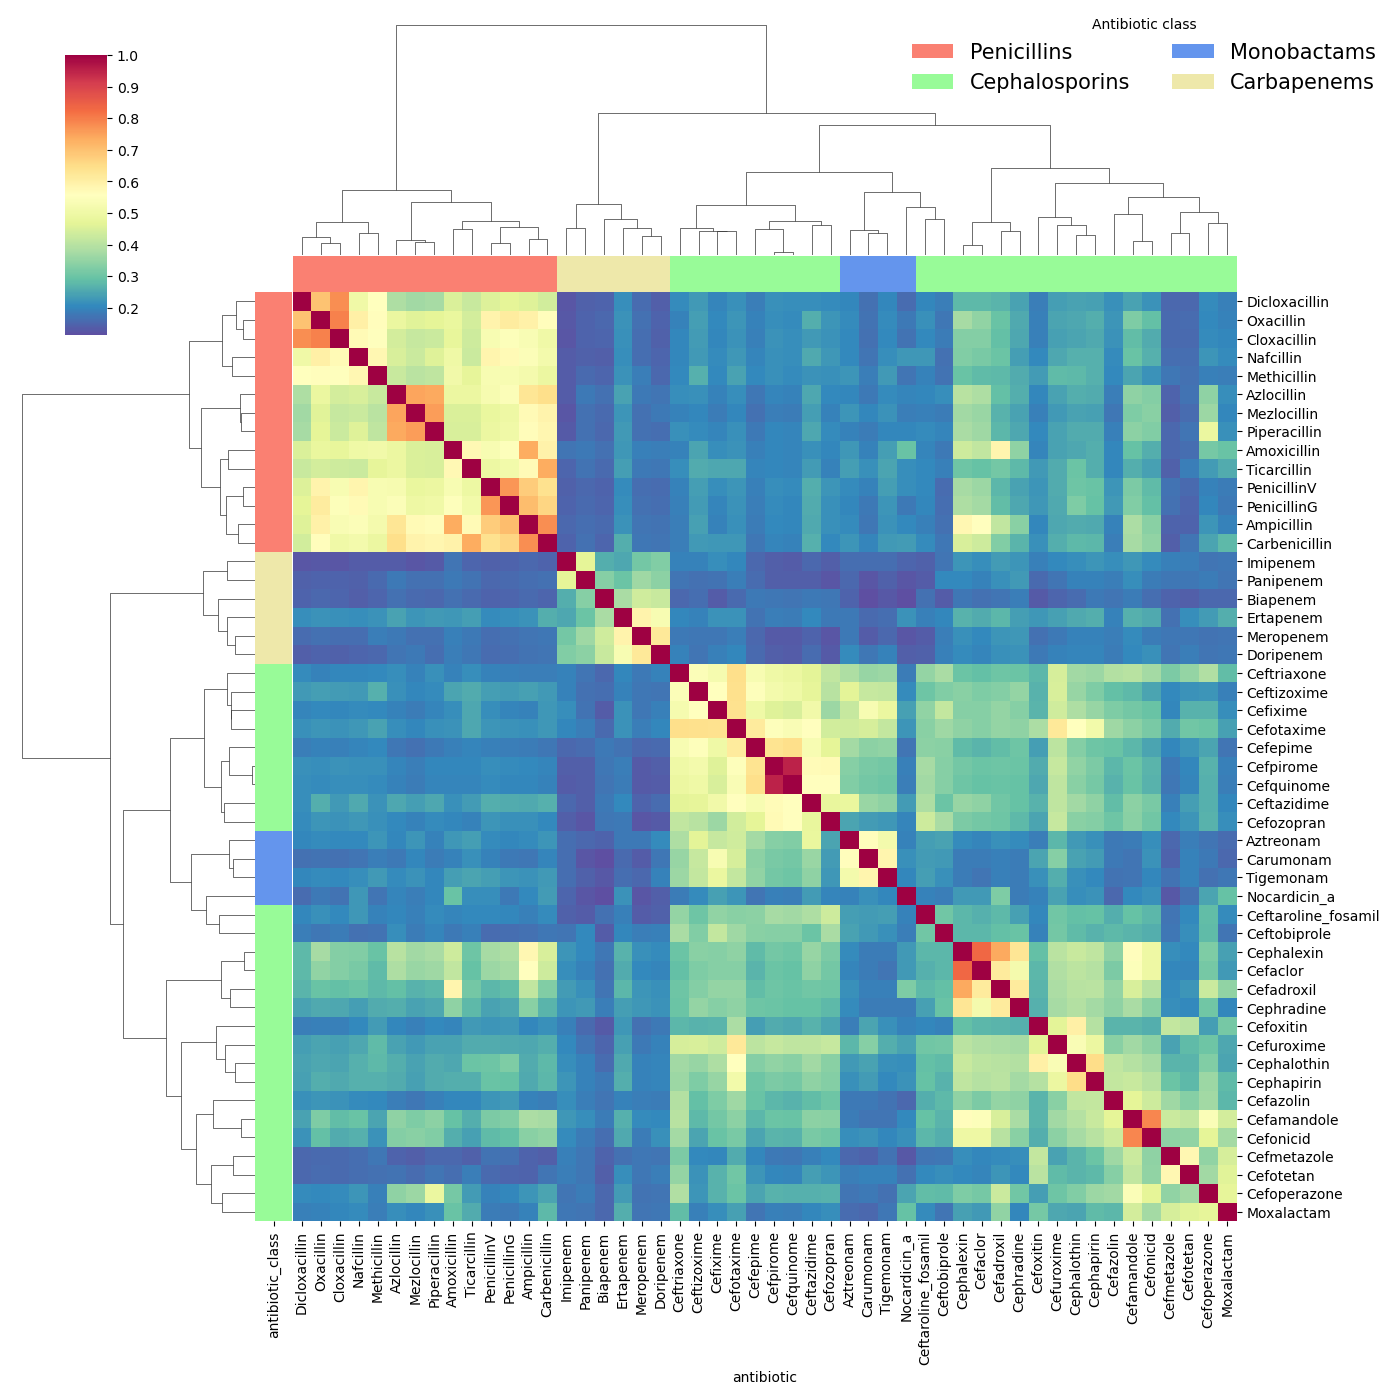

/tmp/ipykernel_1143/3282489028.py:46: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = shc.dendrogram(shc.linkage(dist_matrix, method='ward'),


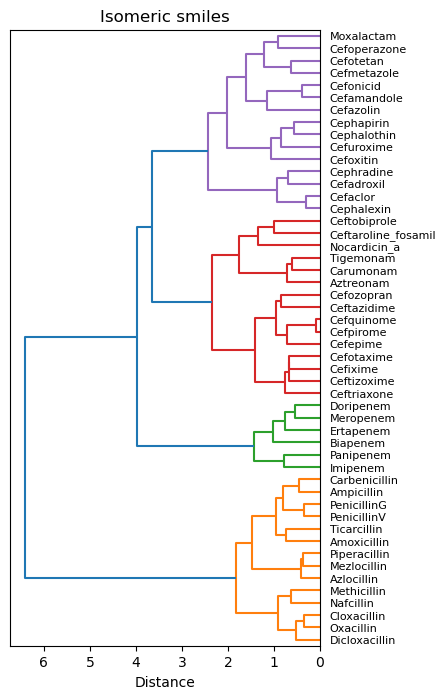

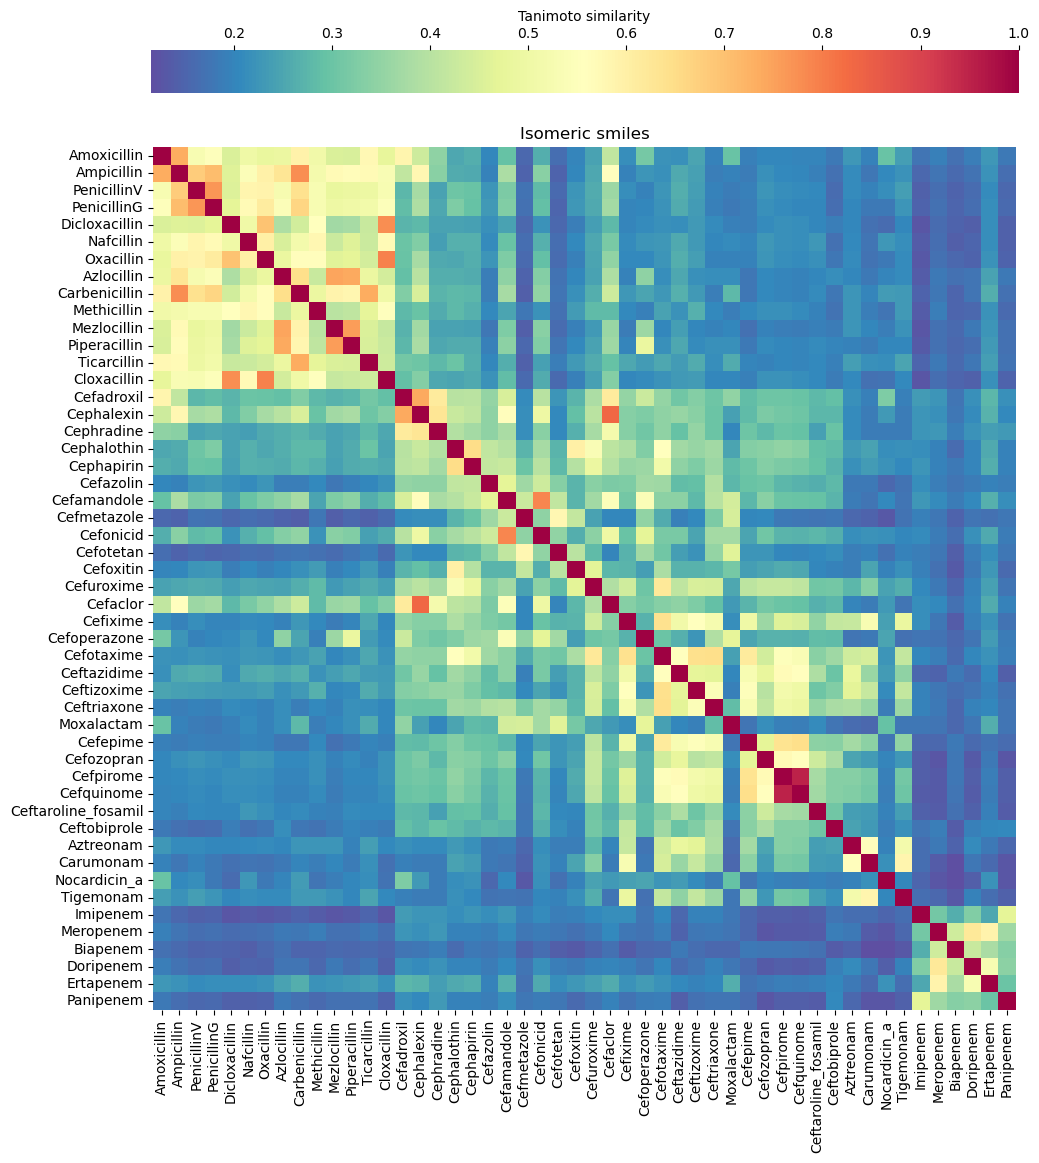

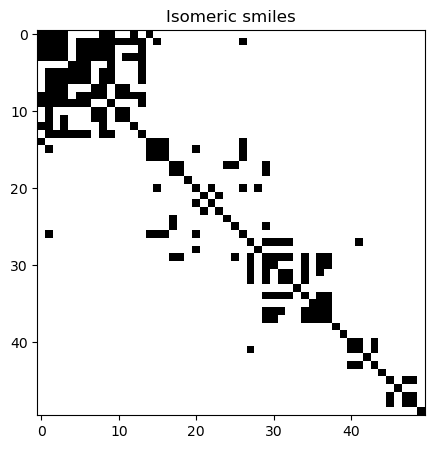

In [27]:
tanimoto_plots(df_smiles.isomeric_smile, "tanimoto_sim_iso", "Isomeric smiles")

extendend plot 

canonical smiles


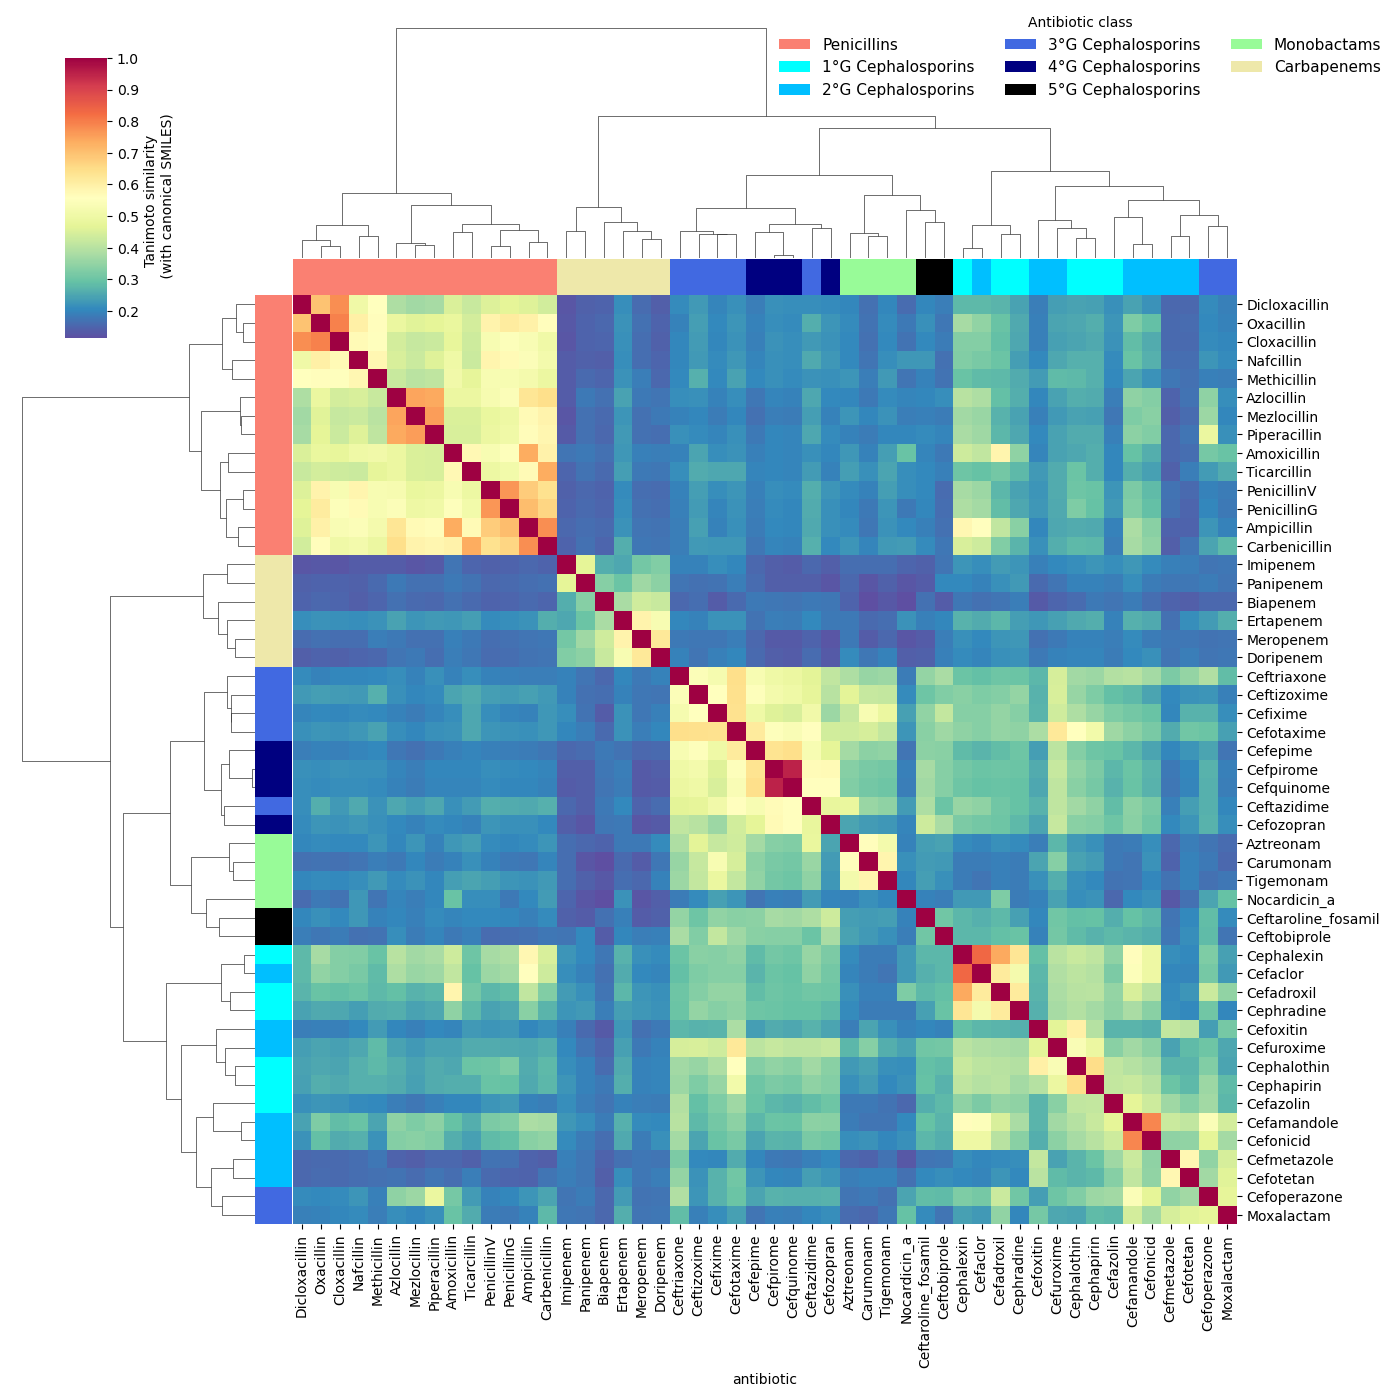

In [31]:
# compute the tanimoto matrix
print("canonical smiles")
sim_matrix = tanimoto_matrix(df_smiles.canonical_smile)

# create a df 
df_sim = pd.DataFrame(sim_matrix, columns = df_smiles.antibiotic)
df_sim["anti_class_expand"] = df_smiles.anti_class_expand
df_sim["antibiotic"] = df_smiles.antibiotic
# drop anti name col
dropcol = df_sim.pop("antibiotic")
# insert column 
df_sim.insert(0, "antibiotic", dropcol)

# cluster plot
# create a color palette and legend structure
colors = df_sim.anti_class_expand.map({
    "Penicillins": "salmon",
    
    "1°G Cephalosporins": "cyan",
    "2°G Cephalosporins": "deepskyblue",
    "3°G Cephalosporins": "royalblue", 
    "4°G Cephalosporins": "navy",
    "5°G Cephalosporins": "black",
    
    "Monobactams": "palegreen",
    "Carbapenems": "palegoldenrod"})
lut = dict(zip(df_sim.anti_class_expand.to_list(), colors))
handles = [Patch(facecolor = lut[name]) for name in lut]

# plot 
df_num = df_sim.select_dtypes(["number"])
sns.clustermap(df_num, method = "ward", metric="euclidean",
    cmap = "Spectral_r", figsize=(14, 14), xticklabels = True, yticklabels = df_sim.antibiotic,
    robust = False, row_colors = colors.to_list(), col_colors = colors.to_list(),
               cbar_pos = (0.05, 0.76, 0.03,0.2), cbar_kws={'label': 'Tanimoto similarity \n (with canonical SMILES)'} )
plt.legend(handles, lut, title = "Antibiotic class", loc = "best", frameon = False, ncol = 3,
    bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, prop={'size': 11})
plt.show()

isomeric smiles


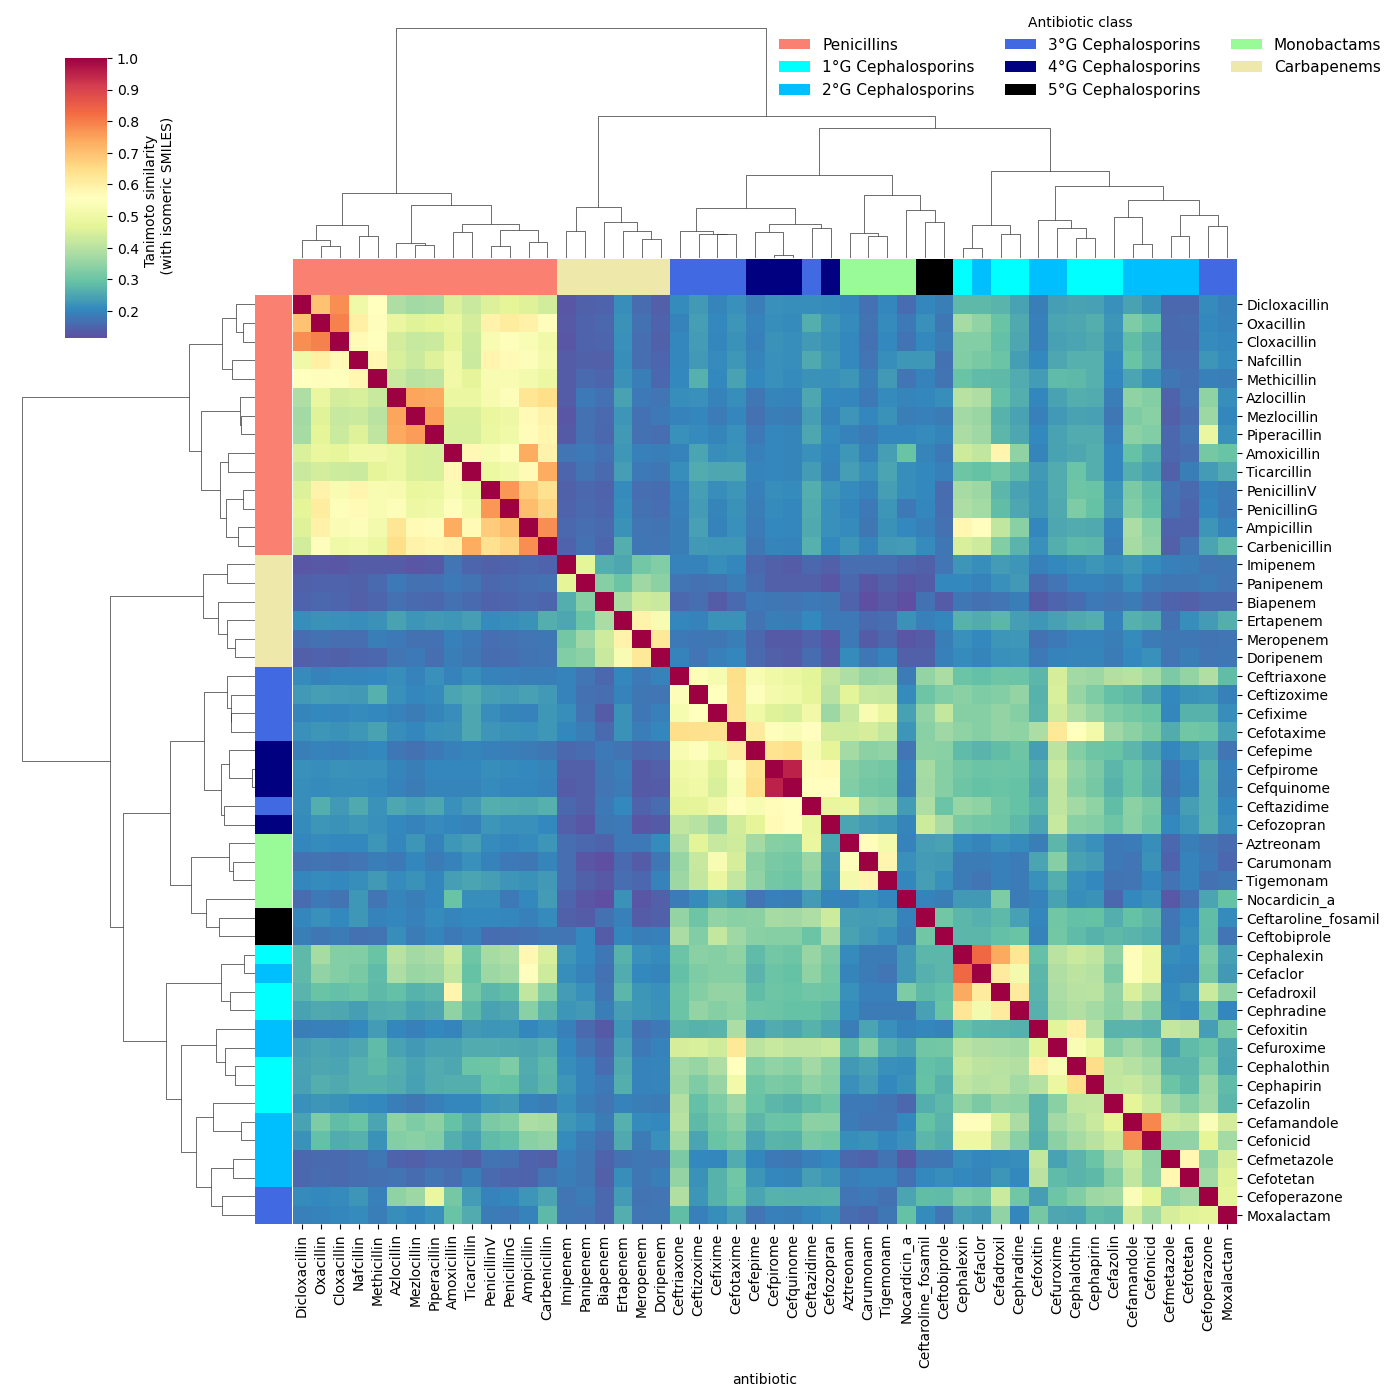

In [32]:
# compute the tanimoto matrix
print("isomeric smiles")
sim_matrix = tanimoto_matrix(df_smiles.isomeric_smile)

# create a df 
df_sim = pd.DataFrame(sim_matrix, columns = df_smiles.antibiotic)
df_sim["anti_class_expand"] = df_smiles.anti_class_expand
df_sim["antibiotic"] = df_smiles.antibiotic
# drop anti name col
dropcol = df_sim.pop("antibiotic")
# insert column 
df_sim.insert(0, "antibiotic", dropcol)

# cluster plot
# create a color palette and legend structure
colors = df_sim.anti_class_expand.map({
    "Penicillins": "salmon",
    
    "1°G Cephalosporins": "cyan",
    "2°G Cephalosporins": "deepskyblue",
    "3°G Cephalosporins": "royalblue", 
    "4°G Cephalosporins": "navy",
    "5°G Cephalosporins": "black",
    
    "Monobactams": "palegreen",
    "Carbapenems": "palegoldenrod"})
lut = dict(zip(df_sim.anti_class_expand.to_list(), colors))
handles = [Patch(facecolor = lut[name]) for name in lut]

# plot 
df_num = df_sim.select_dtypes(["number"])
sns.clustermap(df_num, method = "ward", metric="euclidean",
    cmap = "Spectral_r", figsize=(14, 14), xticklabels = True, yticklabels = df_sim.antibiotic,
    robust = False, row_colors = colors.to_list(), col_colors = colors.to_list(),
    cbar_pos = (0.05, 0.76, 0.03,0.2), cbar_kws={'label': 'Tanimoto similarity \n (with isomeric SMILES)'})
plt.legend(handles, lut, title = "Antibiotic class", loc = "best", frameon = False, ncol = 3,
    bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, prop={'size': 11})
plt.show()

canonical smiles


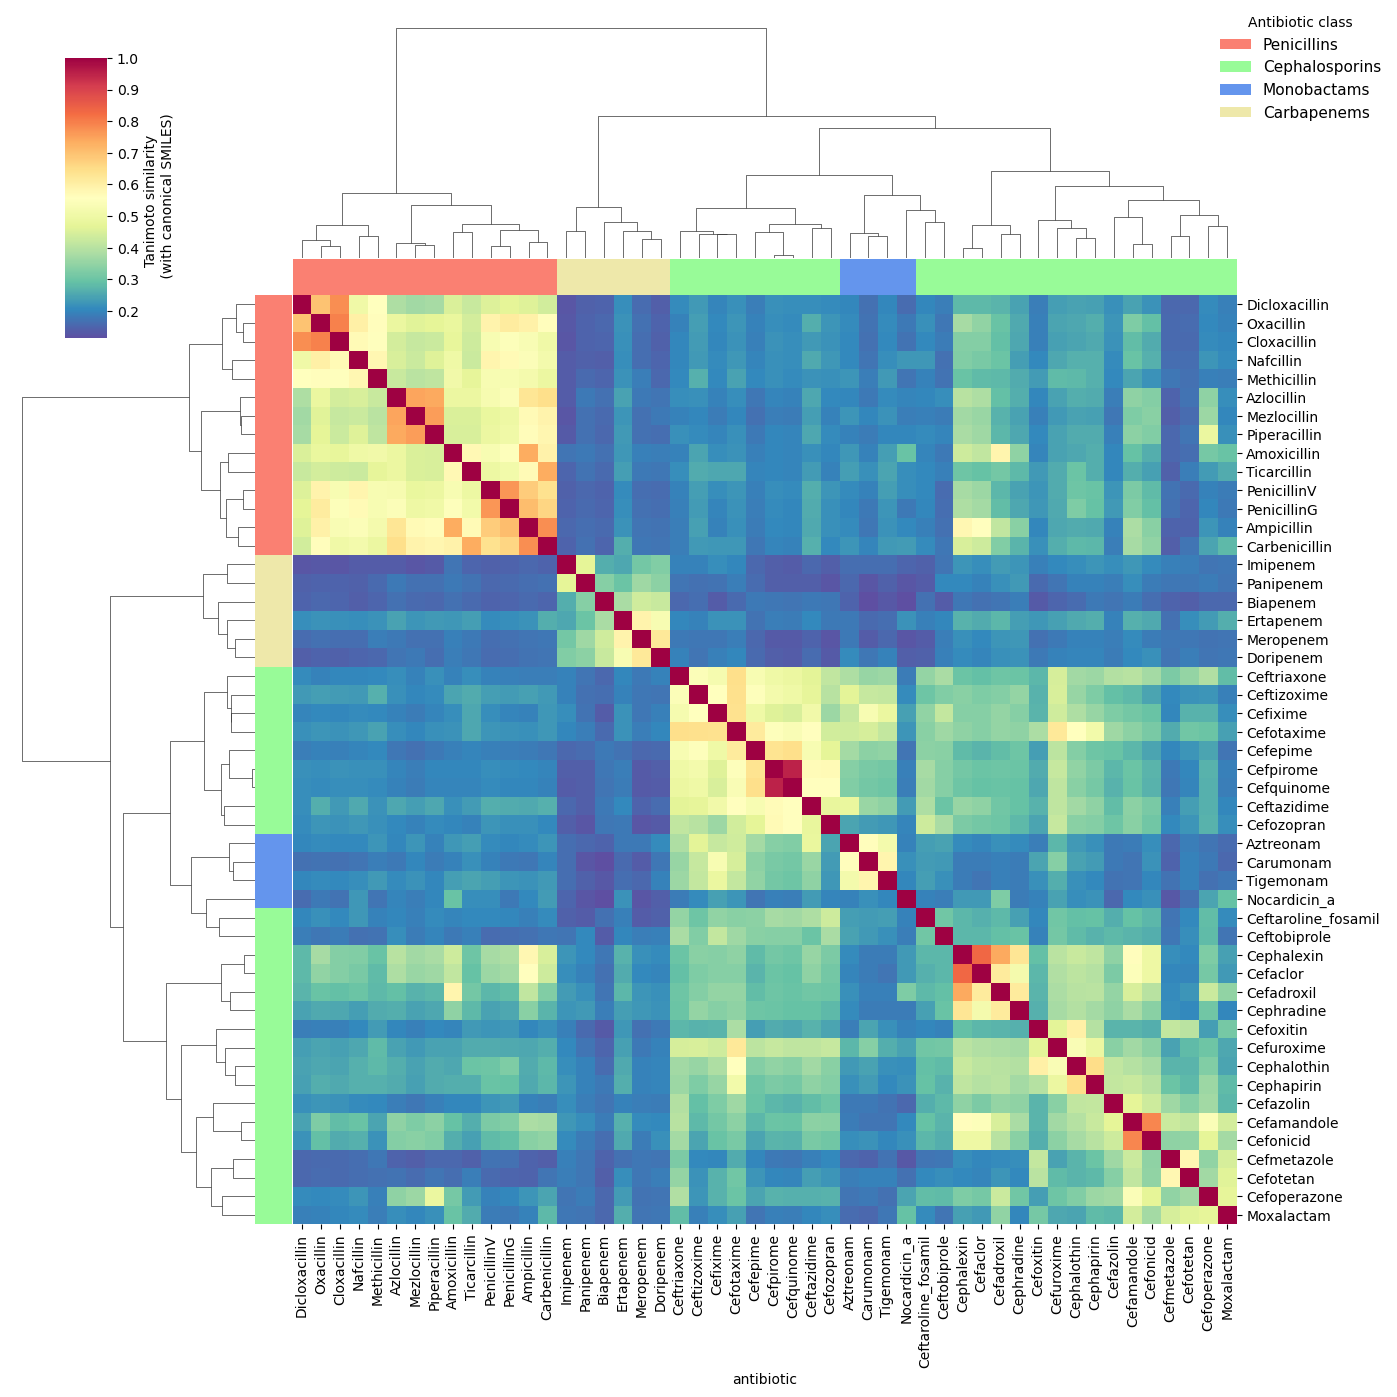

In [38]:
# compute the tanimoto matrix
print("canonical smiles")
sim_matrix = tanimoto_matrix(df_smiles.canonical_smile)

# create a df 
df_sim = pd.DataFrame(sim_matrix, columns = df_smiles.antibiotic)
df_sim["antibiotic_class"] = df_smiles.antibiotic_class
df_sim["antibiotic"] = df_smiles.antibiotic
# drop anti name col
dropcol = df_sim.pop("antibiotic")
# insert column 
df_sim.insert(0, "antibiotic", dropcol)

# cluster plot
# create a color palette and legend structure
colors = df_sim.antibiotic_class.map({
        "Penicillins": "salmon",
        "Cephalosporins": "palegreen",
        "Monobactams": "cornflowerblue",
        "Carbapenems": "palegoldenrod"})
lut = dict(zip(df_sim.antibiotic_class.to_list(), colors))
handles = [Patch(facecolor = lut[name]) for name in lut]

# plot 
df_num = df_sim.select_dtypes(["number"])
sns.clustermap(df_num, method = "ward", metric="euclidean",
    cmap = "Spectral_r", figsize=(14, 14), xticklabels = True, yticklabels = df_sim.antibiotic,
    robust = False, row_colors = colors.to_list(), col_colors = colors.to_list(),
               cbar_pos = (0.05, 0.76, 0.03,0.2), cbar_kws={'label': 'Tanimoto similarity \n (with canonical SMILES)'} )
plt.legend(handles, lut, title = "Antibiotic class", loc = "best", frameon = False, ncol = 1,
    bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, prop={'size': 11})
plt.show()

Fin